# The Price is Right
1. This notebook: create a RAG database with our 400,000 training data
2. 2.1 notebook: visualize in 2D
3. 2.2 notebook: visualize in 3D
4. 2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. 2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [2]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Load in the test pickle file:

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [6]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Random Forest

We will now train a Random Forest model.

Earlier we used the word2vec model to form vectors; this time we'll use the vectors we already have in Chroma, from the SentenceTransformer model.

In [ ]:
# This next line takes an hour on M1 Mac!

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [8]:
# Save the model to a file

joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [7]:
# Load it back in again

rf_model = joblib.load('random_forest_model.pkl')

In [8]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [9]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

c:\Users\Dominik\anaconda3\envs\llms\Lib\asyncio\events.py:84: DeprecationError: 2025-01-27: `modal.Cls.lookup` is deprecated and will be removed in a future release. It can be replaced with `modal.Cls.from_name`.

See https://modal.com/docs/guide/modal-1-0-migration for more information.
  self._context.run(self._callback, *self._args)


In [7]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [8]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $298.20 Truth: $374.41 Error: $76.21 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $198.47 Truth: $225.11 Error: $26.64 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $198.55 Truth: $61.68 Error: $136.87 SLE: 1.34 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $376.84 Truth: $599.99 Error: $223.15 SLE: 0.22 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $221.99 Truth: $16.99 Error: $205.00 SLE: 6.34 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $53.60 Truth: $31.99 Error: $21.61 SLE: 0.25 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $267.74 Truth: $101.79 Error: $165.95 SLE: 0.92 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $239.05 Truth: $289.00 Error: $49.95 SLE: 0.04 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $313.87 Truth: $635.86 Error: $321.99 SLE: 0.50 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $176.14 Truth: $65.99 Error: $110.15 SLE

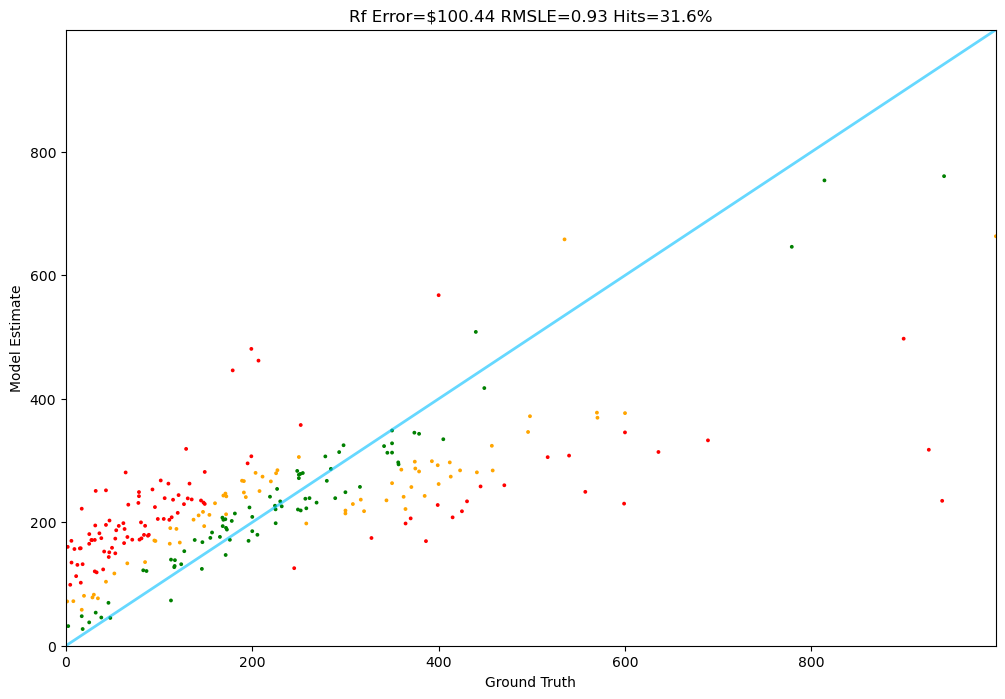

In [12]:
Tester.test(rf, test)

In [13]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [12]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

89.0
195.19
289.9063000000002


In [ ]:
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text)) #
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|██████████| 250/250 [04:28<00:00,  1.07s/it]


In [ ]:
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# mins = [min(s,r) for s,r in zip(specialists, random_forests)]
# maxes = [max(s,r) for s,r in zip(specialists, random_forests)]

# X = pd.DataFrame({
#     'Specialist': specialists,
#     'RandomForest': random_forests,
#     'Min': mins,
#     'Max': maxes,
# })

# Convert y to a Series
y = pd.Series(prices)

In [17]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.44
RandomForest: 0.16
Min: 0.51
Max: 0.09
Intercept=-10.24


In [ ]:
joblib.dump(lr, 'ensemble_model.pkl')

In [9]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

c:\Users\Dominik\anaconda3\envs\llms\Lib\asyncio\events.py:84: DeprecationError: 2025-01-27: `modal.Cls.lookup` is deprecated and will be removed in a future release. It can be replaced with `modal.Cls.from_name`.

See https://modal.com/docs/guide/modal-1-0-migration for more information.
  self._context.run(self._callback, *self._args)


In [14]:
ensemble.price(product)

145.54086785031106

In [10]:
def ensemble_pricer(item):
    return max(0,ensemble.price(description(item)))

1: Guess: $301.70 Truth: $374.41 Error: $72.71 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $173.06 Truth: $225.11 Error: $52.05 SLE: 0.07 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $115.40 Truth: $61.68 Error: $53.72 SLE: 0.38 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $365.57 Truth: $599.99 Error: $234.42 SLE: 0.24 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $95.67 Truth: $16.99 Error: $78.68 SLE: 2.83 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $9.63 Truth: $31.99 Error: $22.36 SLE: 1.28 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $190.17 Truth: $101.79 Error: $88.38 SLE: 0.39 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $306.61 Truth: $289.00 Error: $17.61 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $701.09 Truth: $635.86 Error: $65.23 SLE: 0.01 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $223.06 Truth: $65.99 Error: $157.07 SLE: 1.46

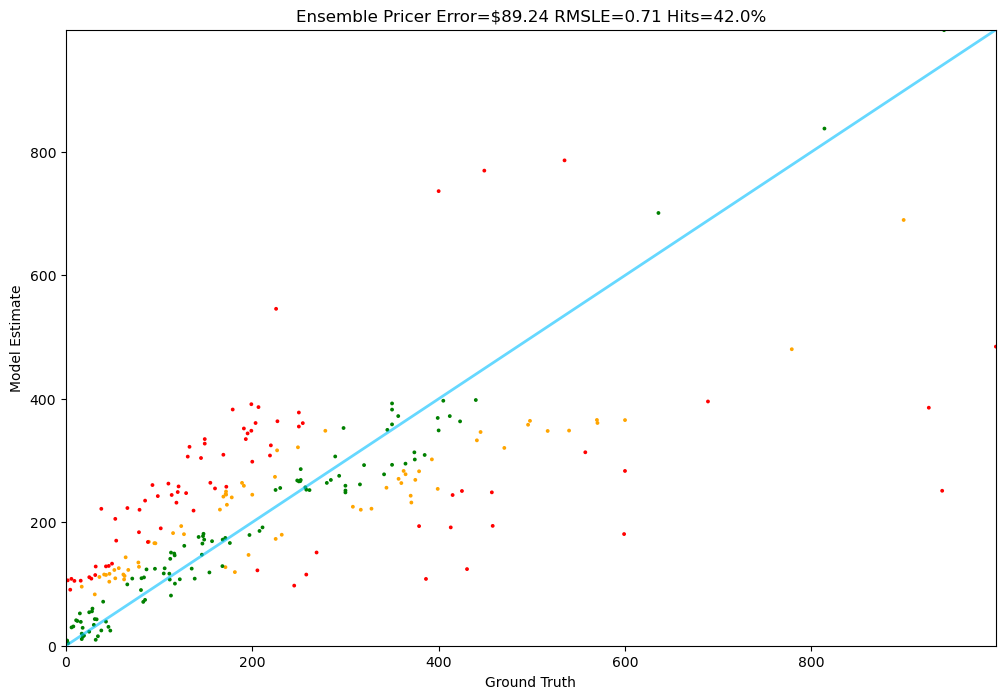

In [11]:
Tester.test(ensemble_pricer, test)

We got done - a Fronter RAG pipeline, a Random Forest model using transformer-based encodings, and an Ensemble model.
